In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device}.')

Using cuda.


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import time

# Data Loading and pre-processing

In [3]:
# You don't need to understand this function for now.
def load_data_CIFAR10(batch_size, resize=None):
    """Download the CIFAR10 dataset and then load it into memory."""
    train_trans = [
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomCrop(32, padding=4),
        torchvision.transforms.RandomRotation(degrees=4),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
        ]
    if resize:
        trans.insert(0, torchvision.transforms.Resize(resize))
    train_trans = torchvision.transforms.Compose(train_trans)
    # the values for mean and std are based on ImageNet common choice
    test_trans = [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ]
    test_trans = torchvision.transforms.Compose(test_trans)
    mnist_train = torchvision.datasets.CIFAR10(
        root="./data", train=True, transform=train_trans, download=True)
    mnist_test = torchvision.datasets.CIFAR10(
        root="./data", train=False, transform=test_trans, download=True)
    return (torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=2),
            torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=2))

In [4]:
batch_size = 128 # Defines the batch size
train_iter, test_iter = load_data_CIFAR10(batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

100%|██████████| 170498071/170498071 [00:01<00:00, 96144560.49it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [5]:
X, y = next(iter(train_iter)) # Requests the first training batch
print(X.size()) # 256 images per batch. Each image is represented by a 1 x 28 x 28 tensor (number of channels x height x width). The images are grayscale, so there is a single channel.
print(y.size())

torch.Size([128, 3, 32, 32])
torch.Size([128])


## Intermediate Block Generator

for creating each intermediate block a class has been definied. This class get the number of convolutional layers, and its layers and parameters.

In [6]:
class BlockGen(nn.Module):
    # Creating Intermediate Blocks
    # the length of param indicates the number of intermediate blocks
    # each parameter is then inside the param for convolutional layers
    def __init__(self, in_channels, out_channels, kernels, c):
        super(BlockGen, self).__init__()
        self.relu = nn.ReLU()
        convs = nn.ModuleList()
        for i in range(c):
            
            convs.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernels[i], padding= 'same'))

        self.model = convs
        # the fully-connected layer turning m to a to calculate the weights of convolutional layer in the final equation the output should be the same value as the number of concolutional layers
        self.fc = nn.Linear(in_channels, c)
        self.batchnorm2d = nn.BatchNorm2d(out_channels)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        m = torch.mean(torch.flatten(x, 2), dim=2)
        a = self.fc(m)
        
        model = self.model
        out_list = []
        for i, mod in enumerate(model):
            weight = a[:, i].unsqueeze(1).unsqueeze(2).unsqueeze(3)
            out = mod(x)
            out_list.append(weight * self.relu(out))

        output = torch.sum(torch.stack(out_list), dim=0)
        return self.batchnorm2d(output)


# Final Model with the output block

In [7]:
class FinalModel(nn.Module):
    # Creating Intermediate Blocks
    # the length of param indicates the number of intermediate blocks
    # each parameter is then inside the param for convolutional layers
    def __init__(self, num_block, c, in_channels, out_channels, kernels):
        super(FinalModel, self).__init__()
        blocks = nn.Sequential()
        for i in range(num_block):
            blocks.append(BlockGen(in_channels=in_channels[i], out_channels=out_channels[i], kernels=kernels, c=c[i]))
            
        self.blocks = blocks
        self.fc2 = nn.Linear(out_channels[-1], 10)

    def forward(self, x):
        # creating the convolutional neurons in the layer of the block
        
        for model in self.blocks:
            x = model(x)

        channel_avg = torch.mean(torch.flatten(x, 2), dim=2)
        out = self.fc2(channel_avg)

        return out

## Defining parameters

In [8]:
num_blocks = 4
c = [3,3,3,3]
kernels = [1,3,5]
in_channels = [3,16,32,64]
out_channels = [16,32,64,128]

In [9]:
# Applies Xavier initialization if the `torch.nn.Module` is `torch.nn.Linear` or `torch.nn.Conv2d`
def init_weights(m):
    if type(m) == torch.nn.Linear or type(m) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)

# num_outputs = 10
model = FinalModel(num_block=num_blocks, c = c, in_channels=in_channels, out_channels=out_channels, kernels= kernels).to(device)
model.apply(init_weights) # Applies `init_weights` to every `torch.nn.Module` inside `model`

FinalModel(
  (blocks): Sequential(
    (0): BlockGen(
      (relu): ReLU()
      (model): ModuleList(
        (0): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1), padding=same)
        (1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (2): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
      )
      (fc): Linear(in_features=3, out_features=3, bias=True)
      (batchnorm2d): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (1): BlockGen(
      (relu): ReLU()
      (model): ModuleList(
        (0): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
        (1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
      )
      (fc): Linear(in_features=16, out_features=3, bias=True)
      (batchnorm2d): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, tra

In [10]:
loss = torch.nn.CrossEntropyLoss()

In [11]:
lr = 0.004
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [12]:
def correct(logits, y):
    y_hat = logits.argmax(axis=1) # Finds the column with the highest value for each row of `logits`.
    return (y_hat == y).float().sum() # Computes the number of times that `y_hat` and `y` match.

In [13]:
def evaluate_metric(model, data_iter, metric):
    """Compute the average `metric` of the model on a dataset."""
    c = torch.tensor(0.).to(device)
    n = torch.tensor(0.).to(device)
    j = 0
    for X, y in data_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X)
        c += metric(logits, y)
        n += len(y)
    return c*100 / n

In [14]:
model.eval()
print(f'Training accuracy: {evaluate_metric(model, train_iter, correct)}. Testing accuracy: {evaluate_metric(model, test_iter, correct)}.')

Training accuracy: 10.194000244140625. Testing accuracy: 10.020000457763672.


## Training


Epoch 1/100.
Training accuracy: 31.809999465942383. Testing accuracy: 27.229999542236328. Duration: 25.674s.

Epoch 2/100.
Training accuracy: 39.71799850463867. Testing accuracy: 38.16999816894531. Duration: 25.615s.

Epoch 3/100.
Training accuracy: 50.36800003051758. Testing accuracy: 48.70000076293945. Duration: 25.543s.

Epoch 4/100.
Training accuracy: 58.24599838256836. Testing accuracy: 56.45000076293945. Duration: 25.428s.

Epoch 5/100.
Training accuracy: 64.86399841308594. Testing accuracy: 63.279998779296875. Duration: 25.567s.

Epoch 6/100.
Training accuracy: 66.34400177001953. Testing accuracy: 65.51000213623047. Duration: 25.555s.

Epoch 7/100.
Training accuracy: 70.59400177001953. Testing accuracy: 68.12000274658203. Duration: 25.478s.

Epoch 8/100.
Training accuracy: 72.9520034790039. Testing accuracy: 71.26000213623047. Duration: 25.544s.

Epoch 9/100.
Training accuracy: 72.70999908447266. Testing accuracy: 70.44999694824219. Duration: 25.543s.

Epoch 10/100.
Training ac

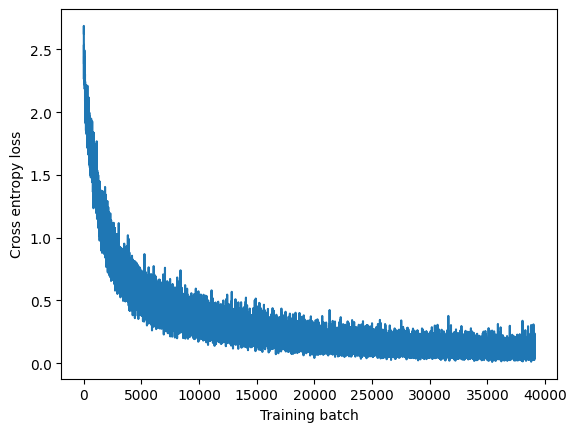

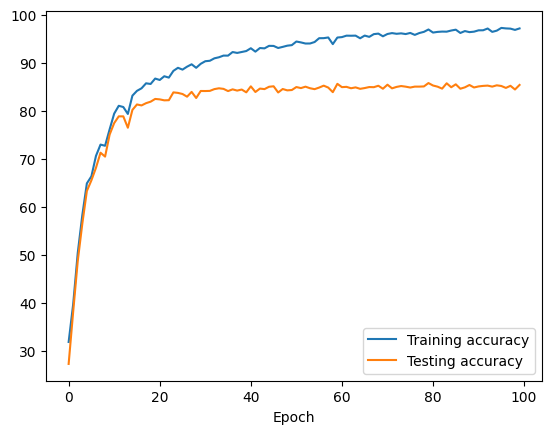

In [15]:
losses = [] # Stores the loss for each training batch
train_accs = [] # Stores the training accuracy after each epoch
test_accs = [] # Stores the testing accuracy after each epoch

num_epochs = 100
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch + 1}/{num_epochs}.')
    start_time = time.perf_counter()

    model.train() # This is necessary because batch normalization behaves differently between training and evaluation

    for X, y in train_iter:
        X, y = X.to(device), y.to(device) # Moves data to `device`
        logits = model(X) # Computes the logits for the batch of images `X`
        l = loss(logits, y) # Computes the loss given the `logits` and the class vector `y`
        optimizer.zero_grad() # Zeroes the gradients stored in the model parameters
        l.backward() # Computes the gradient of the loss `l` with respect to the model parameters

        optimizer.step() # Updates the model parameters based on the gradients stored inside them

        losses.append(float(l)) # Stores the loss for this batch

    model.eval() # This is necessary because batch normalization behaves differently between training and evaluation
    train_accs.append(evaluate_metric(model, train_iter, correct))
    test_accs.append(evaluate_metric(model, test_iter, correct))

    end_time = time.perf_counter()

    print(f'Training accuracy: {train_accs[-1]}. Testing accuracy: {test_accs[-1]}. Duration: {end_time - start_time:.3f}s.') # Computes and displays training/testing dataset accuracy.

plt.plot(losses) # Plots the loss for each training batch
plt.xlabel('Training batch')
plt.ylabel('Cross entropy loss')
plt.show()

plt.plot(list(map(lambda x: x.cpu(),train_accs)), label='Training accuracy')
plt.plot(list(map(lambda x: x.cpu(),test_accs)), label='Testing accuracy')
plt.legend(loc='best')
plt.xlabel('Epoch')
plt.show()

In [16]:
print('best train accuracy: {}'.format(max(train_accs)))
highest_value_index = max(enumerate(train_accs), key=lambda x: x[1])[0]
print('best test accuracy: {}'.format(test_accs[highest_value_index]))

best train accuracy: 97.2760009765625
best test accuracy: 85.16999816894531
